In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(stringr))
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(rstatix)
library(parallel)
library(ggpubr)
library(anndata)
library(ggsci)
library(ggrepel)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4


Attaching package: ‘rstatix’


The following objects are masked from ‘package:plyr’:

    desc, mutate


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    muta

In [2]:
clr_transform <- function(x) {
  if (length(x) == 0) {
    return(NA)  # return NA for empty vectors
  }
  geom_mean <- exp(mean(log(x)))
  return(log(x / geom_mean))
}

In [3]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')

# Y1 D0 vs Y2 D0

In [4]:
meta_data_subset<-meta_data %>% filter(sample.visitName %in% c('Flu Year 1 Day 0','Flu Year 2 Day 0'))

In [5]:
table(meta_data_subset$sample.visitName,meta_data_subset$cohort.cohortGuid)

                  
                   BR1 BR2
  Flu Year 1 Day 0  47  45
  Flu Year 2 Day 0  40  44

In [6]:
H5AD_FILES<-paste0('/home//jupyter/BRI_Analysis/scRNA/h5_cleaned_by_sample/',meta_data_subset$pbmc_sample_id,'.h5ad')

In [7]:
cell_counts_list<-mclapply(H5AD_FILES,function(x){
pbmc <- read_h5ad(x)
cell_counts<-as.data.frame(table(pbmc$obs['AIFI_L3']))
cell_counts$pbmc_sample_id<-as.character(pbmc$obs['pbmc_sample_id'][,1][1])
return(cell_counts)
},mc.cores=60)

In [8]:
count_df<-do.call(rbind,cell_counts_list)
count_df_wide <- pivot_wider(count_df, names_from = AIFI_L3, values_from = Freq)
count_df_wide[is.na(count_df_wide)] <- 0


In [9]:
#count_df<-count_df %>%
  #complete(pbmc_sample_id, AIFI_L3, fill = list(Value = 0))

In [10]:
#count_df[is.na(count_df)] <- 0
count_df<-left_join(count_df,meta_data_subset)


Joining with `by = join_by(pbmc_sample_id)`


In [11]:
count_df<-count_df %>%
  group_by(pbmc_sample_id) %>%
  mutate(total_frequency = sum(Freq), 
         percentage = Freq / total_frequency * 100) %>%
  select(-total_frequency)  %>% dplyr::mutate(percentage_clr = clr_transform((percentage)))%>% ungroup()

In [12]:
write.csv(count_df,'count_df_scRNA.csv')

In [13]:
donor_with_Y1Y2<-names(table(meta_data_subset$subject.subjectGuid)[table(meta_data_subset$subject.subjectGuid)==2])
count_df<-count_df %>% filter(subject.subjectGuid %in% donor_with_Y1Y2)

In [14]:
count_df<-count_df %>%  group_by(AIFI_L3,subject.subjectGuid) %>% mutate(available_n = n()) %>% filter(available_n==2)

In [15]:
Y1=as.data.frame(count_df) %>% filter(AIFI_L3=='Core CD16 monocyte',cohort.cohortGuid=='BR2',sample.visitName=='Flu Year 1 Day 0') %>% arrange(subject.subjectGuid)
Y2=as.data.frame(count_df) %>% filter(AIFI_L3=='Core CD16 monocyte',cohort.cohortGuid=='BR2',sample.visitName=='Flu Year 2 Day 0') %>% arrange(subject.subjectGuid)

In [16]:
head(Y1[c('cohort.cohortGuid','sample.visitName','subject.subjectGuid','percentage','percentage_clr')])

,cohort.cohortGuid,sample.visitName,subject.subjectGuid,percentage,percentage_clr
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,BR2,Flu Year 1 Day 0,BR2002,1.839774,2.026054
2,BR2,Flu Year 1 Day 0,BR2003,2.134669,2.252415
3,BR2,Flu Year 1 Day 0,BR2005,2.570987,2.335643
4,BR2,Flu Year 1 Day 0,BR2008,1.041365,1.469459
5,BR2,Flu Year 1 Day 0,BR2009,1.571181,1.773252
6,BR2,Flu Year 1 Day 0,BR2010,4.082804,3.038969


In [17]:
head(Y2[c('cohort.cohortGuid','sample.visitName','subject.subjectGuid','percentage','percentage_clr')])

,cohort.cohortGuid,sample.visitName,subject.subjectGuid,percentage,percentage_clr
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,BR2,Flu Year 2 Day 0,BR2002,1.8334352,1.920536
2,BR2,Flu Year 2 Day 0,BR2003,1.7210042,2.062529
3,BR2,Flu Year 2 Day 0,BR2005,3.2246979,2.303201
4,BR2,Flu Year 2 Day 0,BR2008,1.0820968,1.569752
5,BR2,Flu Year 2 Day 0,BR2009,0.9436581,1.543810
6,BR2,Flu Year 2 Day 0,BR2010,2.0555654,2.459963


In [18]:
test <- wilcox.test(Y2$percentage_clr , Y1$percentage_clr,
  paired = TRUE
)

In [19]:
test


	Wilcoxon signed rank exact test

data:  Y2$percentage_clr and Y1$percentage_clr
V = 186, p-value = 0.0001791
alternative hypothesis: true location shift is not equal to 0


In [20]:
STAT_res<-as.data.frame(count_df) %>%
  select(percentage_clr,AIFI_L3, subject.subjectGuid,sample.visitName) %>%
  group_by(AIFI_L3) %>% arrange(subject.subjectGuid, sample.visitName) %>%
  wilcox_test(percentage_clr ~ sample.visitName, paired= TRUE) %>%
  adjust_pvalue(method='BH') %>%
  add_significance() 
head(STAT_res)

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
ASDC,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,70,70,1074,0.3260,0.6170238,ns
Activated memory B cell,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,59,59,675,0.1140,0.3519130,ns
Adaptive NK cell,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,1766,0.9340,0.9866912,ns
BaEoMaP cell,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,15,15,21,0.0256,0.1945400,ns
C1Q+ CD16 monocyte,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2357,0.0108,0.1095429,ns
CD4 MAIT,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,77,77,1315,0.3450,0.6170238,ns


In [21]:
STAT_res %>% filter(p.adj<0.05)

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,p.adj,p.adj.signif
<fct>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<chr>
CD14+ cDC2,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2588,3.45e-04,0.0081650,**
Core CD14 monocyte,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2626,1.78e-04,0.0063190,**
Core CD16 monocyte,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2706,4.04e-05,0.0028684,**
ISG+ CD56dim NK cell,percentage_clr,Flu Year 1 Day 0,Flu Year 2 Day 0,84,84,2482,1.89e-03,0.0335475,*


In [22]:
max_y<-count_df %>%
  select(percentage_clr, AIFI_L3, sample.visitName) %>%
  distinct() %>%
  group_by(AIFI_L3) %>%
  dplyr::summarize(max_frequency_clr = max(percentage_clr)) %>%
  ungroup() %>% arrange(AIFI_L3) %>% select(max_frequency_clr) %>% pull()

Adding missing grouping variables: `subject.subjectGuid`


In [23]:
STAT_res<-STAT_res%>% arrange(AIFI_L3)

In [24]:
STAT_res$max_y<-max_y*1.1

In [25]:
STAT_res$p<-round(STAT_res$p,4)
STAT_res$p.adj<-round(STAT_res$p.adj,4)

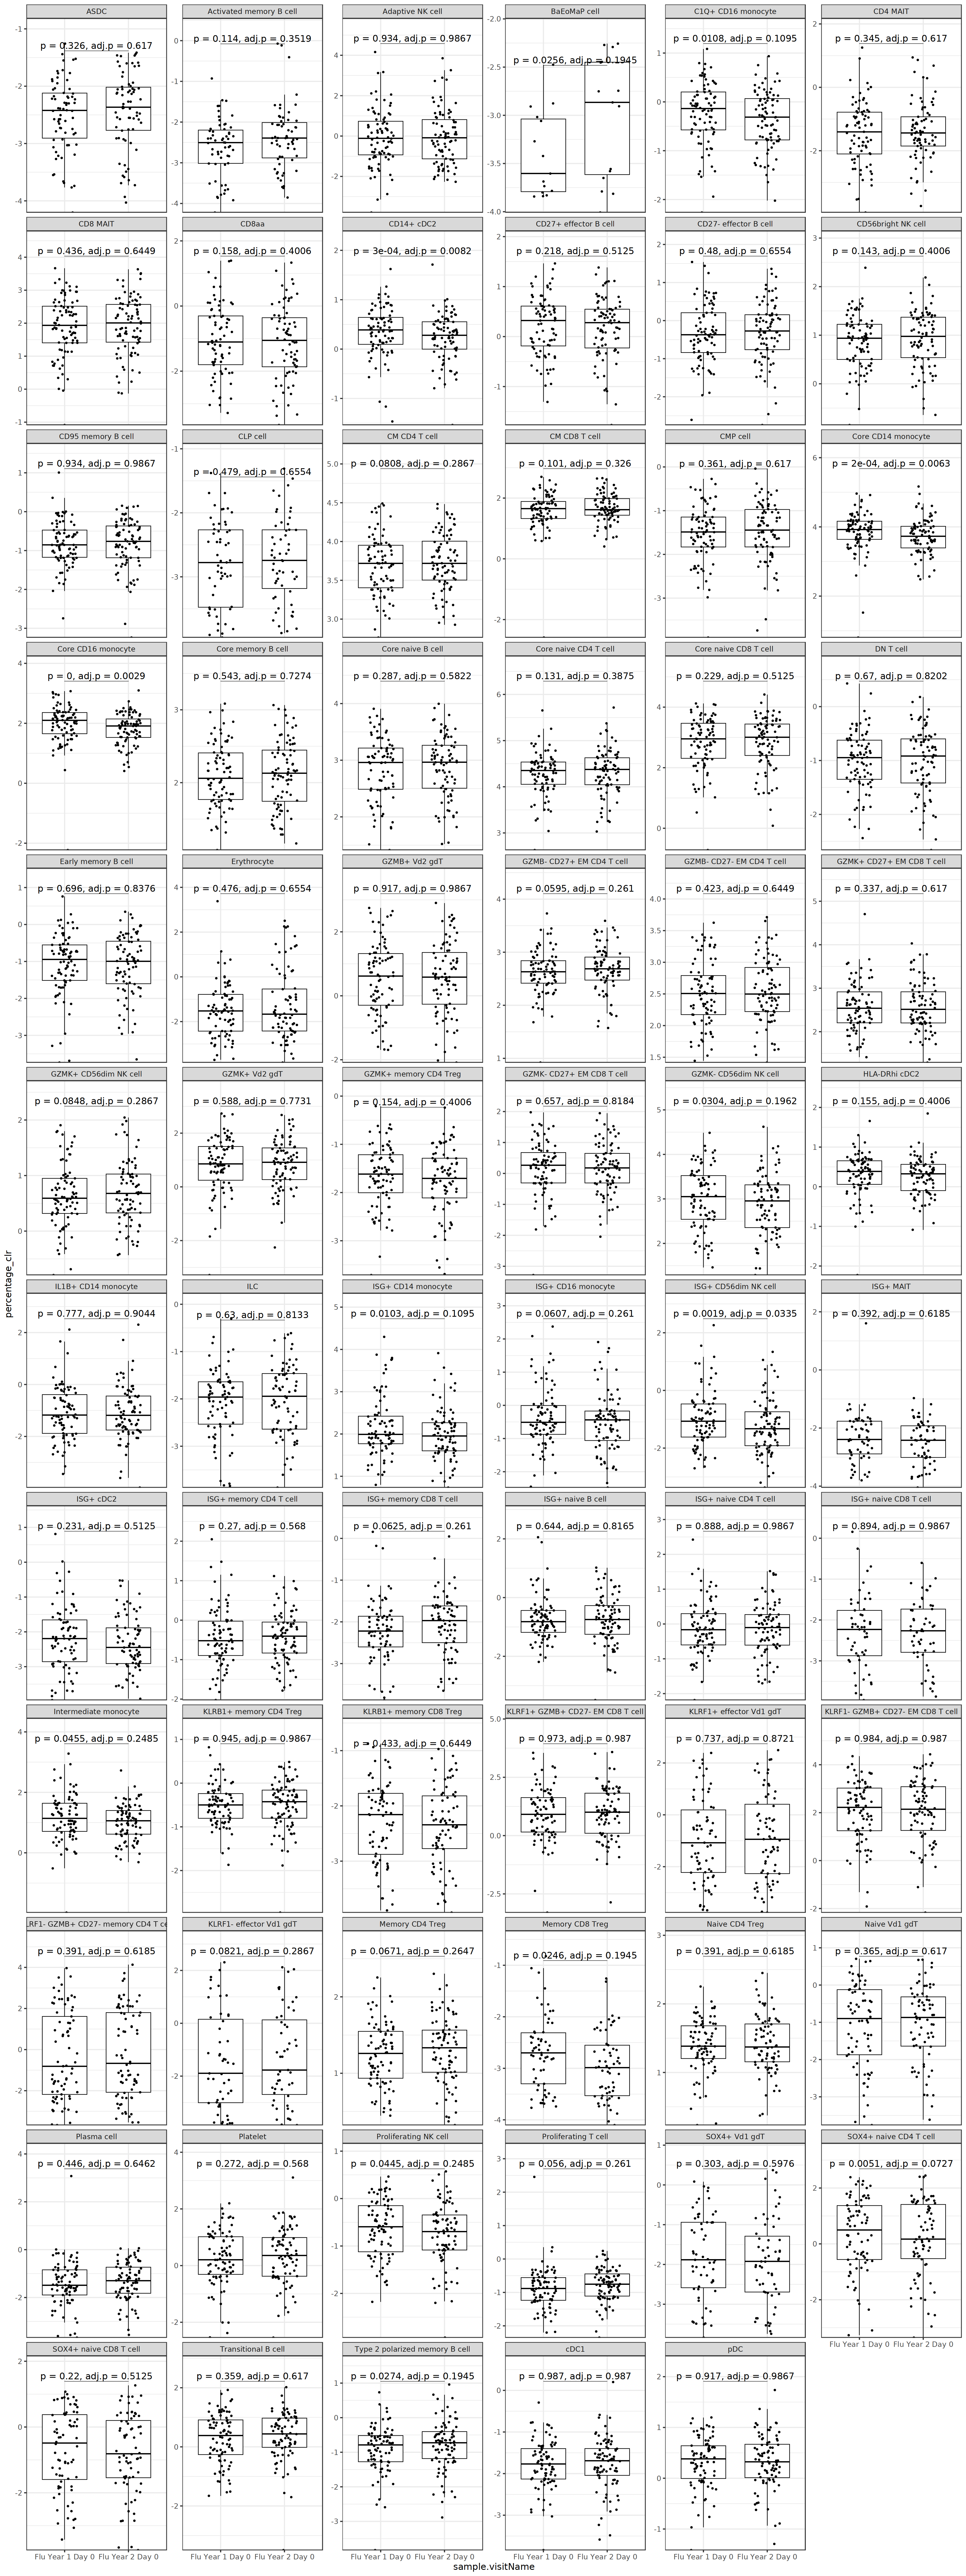

In [26]:
options(repr.plot.width = 30, repr.plot.height = 80)


ggboxplot(count_df , 
          x = "sample.visitName", 
          y = "percentage_clr",
          palette = "jco",
          add = "jitter")+
facet_wrap(~AIFI_L3,
           scale='free_y',
           ncol=6)+   
stat_pvalue_manual(STAT_res, 
                   label = "p = {p}, adj.p = {p.adj}", 
                   tip.length = 0, 
                   y.position = 'max_y',
                   x.position=0.5,
                   size=7) +
theme_bw(base_size=20)+
scale_y_continuous(limits = c(NA, NA), 
                   expand = expansion(mult = c(0, 0.15)))